In [2]:
"""
Sample from the trained model with PyTorch
"""
import json
from contextlib import nullcontext
import torch
import os, sys
from pathlib import Path

# Support absolute imports for a standalone script
sys.path.insert(0, Path.cwd().parent.as_posix())


from model import ModelArgs, Transformer, softmax_sum
from tokenizer import Tokenizer
from tinystories import get_tokenizer_model_path

# -----------------------------------------------------------------------------
start = (
    ""  # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
)
max_new_tokens = 25  # number of tokens generated in each sample
temperature = (
    0  # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
)
top_k = (
    300  # retain only the top_k most likely tokens, clamp others to have 0 probability
)
tokenizer = ""  # override the tokenizer model path
seed = 1337
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)  # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
# dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
dtype = "float16"
compile = False  # use PyTorch 2.0 to compile the model to be faster

softmax0_run = "softmax0-15m-2023_08_26_00_08_49"
softmax1_run = "softmax1-15m-2023_08_25_11_47_04"
softmax1_110m_run = "artifacts/l83srejz_model:v49"
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
device_type = "cuda" if "cuda" in device else "cpu"  # for later use in torch.autocast
ptdtype = {
    "float32": torch.float32,
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
}[dtype]
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)


def load_model(out_dir):
    # init from a model saved in a specific directory
    checkpoint_dict = torch.load(f"{out_dir}/ckpt.pt", map_location=device)
    # del flash if exists
    if "flash" in checkpoint_dict["model_args"]:
        del checkpoint_dict["model_args"]["flash"]
    # softmax -> softmax1 in model_args
    if "softmax" in checkpoint_dict["model_args"]:
        checkpoint_dict["model_args"]["softmax1"] = checkpoint_dict["model_args"][
            "softmax"
        ]
        del checkpoint_dict["model_args"]["softmax"]
    gptconf = ModelArgs(**checkpoint_dict["model_args"])
    model = Transformer(gptconf)
    state_dict = checkpoint_dict["model"]
    unwanted_prefix = "_orig_mod."
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix) :]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=False)

    model.eval()
    model.to(device)
    if compile:
        print("Compiling the model...")
        model = torch.compile(model)  # requires PyTorch 2.0 (optional)

    return model


def load_tokenizer(out_dir):
    # load the tokenizer
    with open(f"{out_dir}/config.json", "r") as f:
        config = json.load(f)
    vocab_source = config.get("vocab_source", "llama2")
    vocab_size = config["vocab_size"]
    if tokenizer:
        # a specific tokenizer is provided, use it
        tokenizer_model = tokenizer
    else:
        # let's try to find the tokenizer model automatically. bit gross here...
        query_vocab_size = 0 if vocab_source == "llama2" else vocab_size
        tokenizer_model = get_tokenizer_model_path(vocab_size=query_vocab_size)
    enc = Tokenizer(tokenizer_model="../tokenizer.model")
    return enc


# model_softmax0 = load_model(f'../out/{softmax0_run}')
model_softmax1 = load_model(f"../out/{softmax1_run}")
# model_softmax1_110m = load_model(f'../{softmax1_110m_run}')
enc = load_tokenizer(f"../out/{softmax1_run}")


def encode_prompt(start):
    if start.startswith("FILE:"):
        with open(start[5:], "r", encoding="utf-8") as f:
            start = f.read()
    start_ids = enc.encode(start, bos=True, eos=False)
    x = torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...]
    return x


# run generation
@torch.no_grad()
def generate(
    model=model_softmax1,
    prompt=start,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_k=top_k,
    split_token=False,
):
    x = encode_prompt(prompt)
    with ctx:
        y = model.generate(x, max_new_tokens, temperature, top_k)
        if split_token:
            return [enc.decode([token]) for token in y.tolist()[0]]
        return enc.decode(y.tolist())[0]

In [3]:
import torch.nn.functional as F

def compute_perplexity(prompt, model=model_softmax1, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k):
	"""
	Compute the perplexity given the logits of generated tokens and their corresponding indices.
	"""
	x = encode_prompt(prompt)
	idx, logits = model.generate(x, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k, return_logits=True)
	probs = F.softmax(logits, dim=-1)
	actual_probs = torch.gather(probs, -1, idx.unsqueeze(-1)[:, x.shape[1]:, :])
	neg_log_probs = -torch.log(actual_probs)
	return torch.exp(torch.mean(neg_log_probs)).item()

In [4]:
generate(model_softmax1, "Sally sold seashells by the")
S = torch.stack(softmax_sum)
S.shape

torch.Size([6, 6, 9])

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from functools import partial

def attnsum_layer_heatmap(data, layer_num, ax, vmin=0.5, vmax=1.0):
	"""
	Plot a heatmap for the specified layer's softmax attention score sums.
	
	Parameters:
	- data: 3D numpy array containing the attention scores.
	- layer_num: Layer number to plot.
	- ax: Matplotlib axis object to plot on.
	- vmin, vmax: Color scale limits.
	"""
	ax.imshow(data[layer_num], aspect='auto', cmap='inferno', vmin=vmin, vmax=vmax)
	ax.set_title(f'Layer {layer_num+1} Heatmap')
	ax.set_ylabel('Attention Heads')
	ax.set_xlabel('Seq Length')
	ax.figure.colorbar(mappable=ax.get_images()[0], ax=ax)

def attnsum_layer_histogram(data, layer_num, ax):
	"""
	Plot a histogram for the specified layer.
	
	Parameters:
	- data: 3D numpy array containing the attention scores.
	- layer_num: Layer number to plot.
	- ax: Matplotlib axis object to plot on.
	- bin_edges: Bin edges for the histogram.
	"""
	ax.hist(data[layer_num].flatten(), bins=50, color='cornflowerblue', alpha=0.8, log=True)
	ax.set_title(f'Layer {layer_num+1} Attention Distribution')
	ax.set_xlabel('Attention Score Sum')
	ax.set_ylabel('Frequency (Log)')

def attnsum_layer(S, layer_num):
	"""
	Wrapper function to plot both heatmap and histogram for a specified layer.
	
	Parameters:
	- layer_num: Layer number to plot.
	"""
	fig, axes = plt.subplots(1, 2, figsize=(15, 5))
	
	# Plot heatmap on the first axis
	attnsum_layer_heatmap(S, layer_num, axes[0])
	
	# Plot histogram on the second axis
	attnsum_layer_histogram(S, layer_num, axes[1])
	
	plt.tight_layout()
	plt.show()

def interactive_attnsum_layer(S):
	"""
	Plot softmax1's attention score sums, per layer, interactively with iPython sliders.

	Parameters:
	- S (Tensor): Attention score sums.
	"""
	# Create an interactive slider for layer selection
	print(S.shape)
	layer_slider = widgets.IntSlider(value=0, min=0, max=S.shape[0]-1, step=1, description='Layer Num:')
	plot = widgets.interactive_output(partial(attnsum_layer, S), {'layer_num': layer_slider})

	interactive_plot = widgets.VBox([layer_slider, plot])

	return interactive_plot

def rolling_window(data, window_size):
    """Apply a rolling window average to data."""
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

def attnsum_all(softmax_data):
	"""
	Plot a heatmap and histogram for the concatenated activations across all layers.

	Parameters:
	- softmax_data: 3D numpy array containing the activations.
	"""
	# Concatenate activations along the attention heads dimension
	concat_activations = softmax_data.reshape(-1, softmax_data.shape[-1])
	num_heads = softmax_data.shape[1]

	# Min of activations over seq
	min_activations = torch.min(softmax_data, dim=1).values

	fig = plt.figure(figsize=(8, 8))
	gs = fig.add_gridspec(2,2)
	axes = [fig.add_subplot(gs[:, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]

	# Plot heatmap for concatenated activations
	axes[0].imshow(concat_activations, aspect='auto', cmap='inferno')
	axes[0].set_title('Attention Score Sums')
	axes[0].set_ylabel('nth Attention Head of mth Block')
	axes[0].set_xlabel('Sequence Length')
	axes[0].figure.colorbar(mappable=axes[0].get_images()[0], ax=axes[0])
 
	

	# Plot histogram for all flattened values
	axes[1].hist(min_activations.flatten(), bins=15, color='cornflowerblue', edgecolor='black')
	axes[1].set_title('Smallest Attention Score Sum over Sequence')
	axes[1].set_xlabel('Min Attention Score / Head / Layer')
	axes[1].set_ylabel('Frequency')

	# Find bottom 10% of mean values
	threshold = torch.quantile(concat_activations.mean(dim=1), 0.1)
	
	# Plot multiline plot for concatenated activations
	bottom_activations = []
	for i, line in enumerate(concat_activations):
		if line.mean() <= threshold:
			axes[2].plot(rolling_window(line.numpy(), 4), label=f'Head {i//num_heads} Layer {i%num_heads}', alpha=0.5)
			bottom_activations.append(line)
	bottom_activations = torch.stack(bottom_activations)

	axes[2].plot(rolling_window(bottom_activations.mean(dim=0).numpy(), 4), label='Mean', color='black', linewidth=2)

	axes[2].set_title('Attention Sum over Sequence (Mean of Bottom 10%)')
	axes[2].set_xlabel('Sequence Length')
	axes[2].set_ylabel('Attention Sum (Smoothened)')
	axes[2].legend()


	plt.tight_layout()
	plt.show()

/var/folders/kq/mtjf6mbj4rv07rcz7sq40s6w0000gn/T/ipykernel_49912/2959644649.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  data, cmap=plt.cm.get_cmap("inferno", 12), vmin=global_min


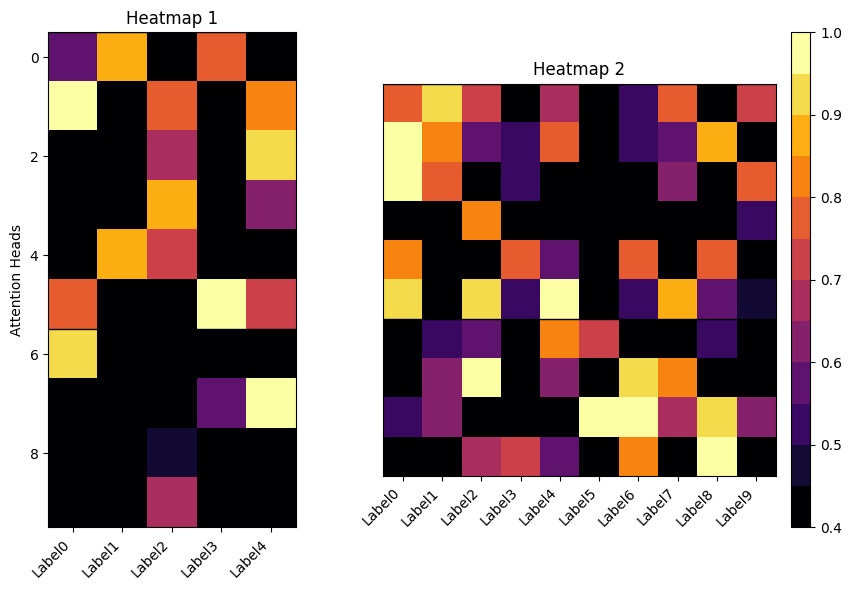

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def create_heatmap_subplots(
    data_list,
    x_labels_list,
    titles_list,
    shared_y_ticks=True,
    x_label_rotation=-90,
    red_lines=None,
):
    n = len(data_list)  # Number of heatmaps

    # Calculate the minimum value among all values of all heatmaps
    global_min = np.min([np.min(data) for data in data_list])

    # Create a grid of subplots using gridspec
    fig = plt.figure(
        figsize=(3 * (n + 1), 6), facecolor="none"
    )  # Set facecolor to 'none' for transparency
    gs = gridspec.GridSpec(
        1, n + 1, width_ratios=[1] * n + [0.05]
    )  # n columns for heatmaps, 1 for colorbar

    heatmaps = []
    x_ticks_list = []

    for i, data in enumerate(data_list):
        heatmap_ax = plt.subplot(gs[i])
        heatmap = heatmap_ax.imshow(
            data, cmap=plt.cm.get_cmap("inferno", 12), vmin=global_min
        )  # Set vmin to global_min

        # Adjust the color scale for each heatmap
        heatmap.set_clim(
            vmin=0.4, vmax=1
        )  # Set vmax to the max of the current heatmap

        # Calculate the number of x-ticks based on the data shape
        num_x_ticks = data.shape[1]
        x_ticks = np.arange(num_x_ticks)
        x_ticks_list.append(x_ticks)

        # Set shared x-ticks for all heatmaps
        heatmap_ax.set_xticks(x_ticks)

        # Add vertical black lines where y % 6 == 0
        y_ticks = np.arange(data.shape[0])
        for y in y_ticks:
            if y % 6 == 0:
                heatmap_ax.axhline(y - 0.5, color="black", linewidth=1)

        # Add red vertical lines at specified positions before the end of the heatmap
        if red_lines is not None:
            heatmap_ax.axvline(red_lines[i] - 0.5, color="blue", linewidth=2)

        if i > 0 and shared_y_ticks:
            heatmap_ax.set_yticks([])  # Hide y-ticks for all but the first heatmap
        else:
            heatmap_ax.set_ylabel("Attention Heads")

        # Set distinct x-labels for each heatmap
        x_labels = x_labels_list[i]

        # Tilt x-labels at an angle
        heatmap_ax.set_xticklabels(
            x_labels, rotation=x_label_rotation, ha="right"
        )  # Adjust rotation angle as needed

        heatmaps.append(heatmap)

        # Set custom titles for each heatmap
        title = titles_list[i]
        heatmap_ax.set_title(title)

    # Add a colorbar to the right of the subplots
    cax = plt.subplot(gs[n])  # Colorbar axes
    cbar = plt.colorbar(heatmaps[-1], cax=cax)

    plt.tight_layout()
    plt.show()


# Generate example data for n heatmaps
data_list = [np.random.rand(10, 5), np.random.rand(10, 10)]

# Set distinct x-labels, titles, and other parameters for each heatmap
x_labels_list = [
    ["Label0", "Label1", "Label2", "Label3", "Label4"],
    [
        "Label0",
        "Label1",
        "Label2",
        "Label3",
        "Label4",
        "Label5",
        "Label6",
        "Label7",
        "Label8",
        "Label9",
    ],
]

titles_list = ["Heatmap 1", "Heatmap 2"]

create_heatmap_subplots(
    data_list, x_labels_list, titles_list, shared_y_ticks=True, x_label_rotation=45
)

/var/folders/kq/mtjf6mbj4rv07rcz7sq40s6w0000gn/T/ipykernel_49912/2959644649.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  data, cmap=plt.cm.get_cmap("inferno", 12), vmin=global_min


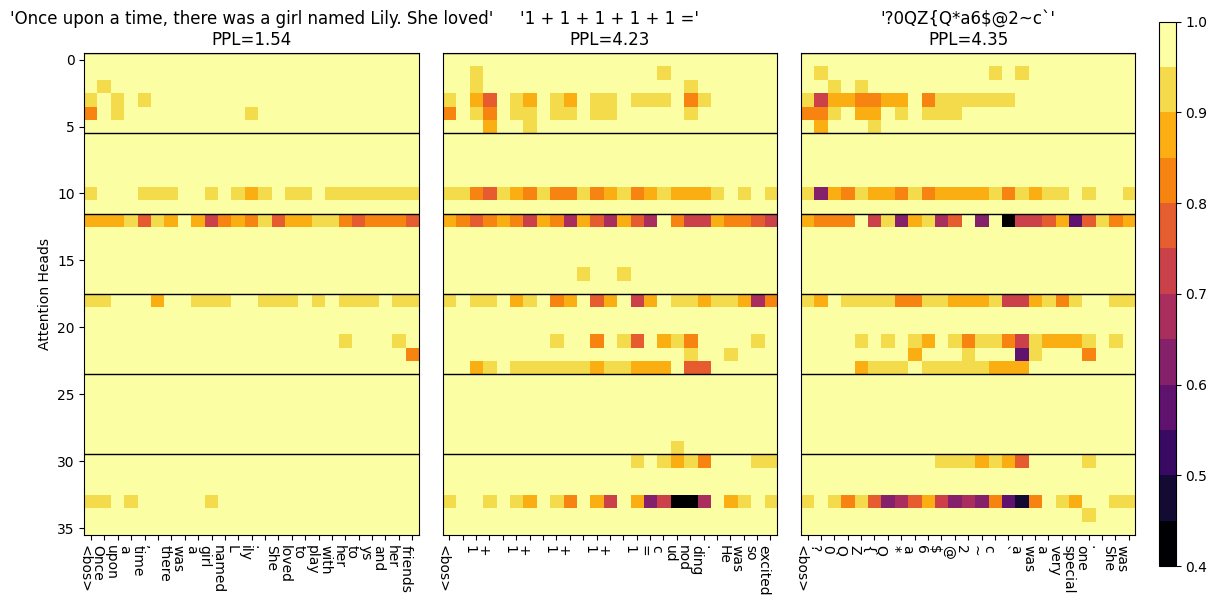

In [7]:
prompts = [
    "Once upon a time, there was a girl named Lily. She loved",
    "1 + 1 + 1 + 1 + 1 =",
    "?0QZ{Q*a6$@2~c`",
]

token_arr, sums_arr, ppls = [], [], []
for p in prompts:
    tokens = generate(prompt=p, max_new_tokens=10, split_token=True)
    tokens[0] = "<bos>"
    from model import softmax_sum

    sums = torch.stack(softmax_sum)
    sums = sums.reshape(-1, sums.shape[-1]).numpy()
    ppl = compute_perplexity(p, max_new_tokens=max_new_tokens)
    ppls.append(ppl)
    token_arr.append(tokens[:-1])
    sums_arr.append(sums)

titles = [f"'{p}'\nPPL={ppl:.2f}" for p, ppl in zip(prompts, ppls)]
create_heatmap_subplots(sums_arr, token_arr, titles)

Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine.
torch.Size([6, 6, 25])
Token Count: 25
Perplexity: 1.3256
Overall Min: 0.5698
torch.Size([6, 6, 25])


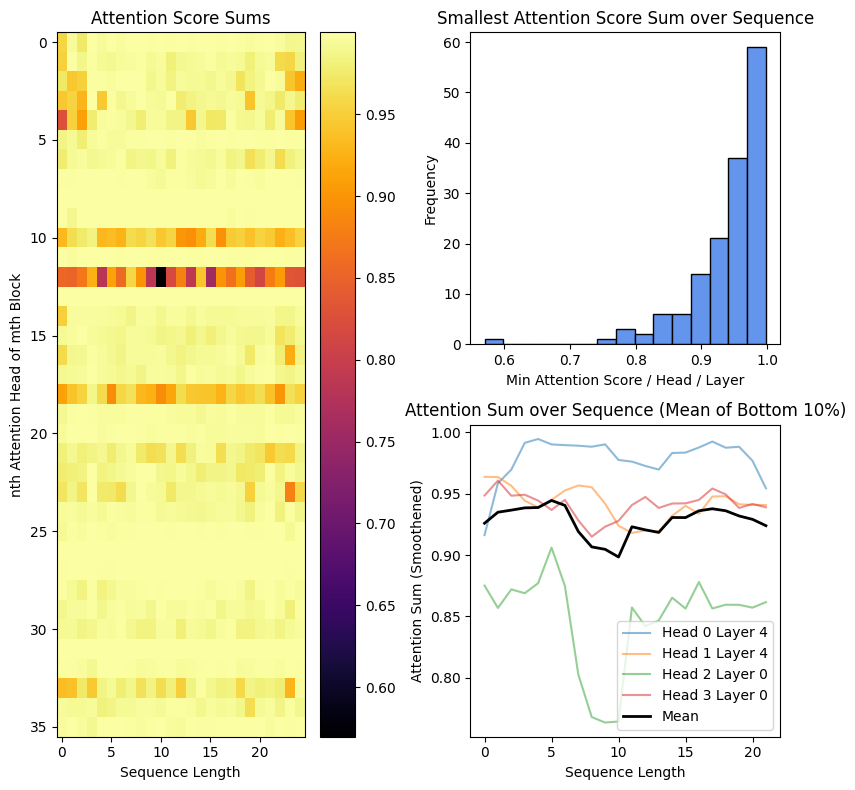

In [8]:
prompt ="Once upon a time,"
max_new_tokens = 20

ppl = compute_perplexity(prompt, max_new_tokens=max_new_tokens)
print(generate(prompt=prompt, max_new_tokens=max_new_tokens))
from model import softmax_sum
S = torch.stack(softmax_sum)
print(S.shape)
print(f"Token Count: {S.shape[2]}")
print(f'Perplexity: {ppl:.4f}')
print(f"Overall Min: {S.min().item():.4f}")
display(interactive_attnsum_layer(S))
attnsum_all(S)

In [9]:
import matplotlib.pyplot as plt

def plot_multi_scale_line_chart(timesteps, lists, list_labels, list_colors):
    """
    Plot multiple lists on the same line chart with their own scales.
    
    Args:
        timesteps (list): List of timesteps for the x-axis.
        lists (list of lists): List of data lists to be plotted.
        list_labels (list of str): List of labels for the data lists.
        list_colors (list of str): List of colors for the data lines.
    """
    # Create a figure and axis
    fig, ax1 = plt.subplots()

    # Loop through the lists and plot data on separate y-axes
    for i, (data, label, color) in enumerate(zip(lists, list_labels, list_colors)):
        ax = ax1 if i == 0 else ax1.twinx()  # Use the first y-axis for the first list

        ax.plot(timesteps, data, color=color, label=label)
        ax.set_ylabel(label, color=color)
        ax.tick_params(axis='y', labelcolor=color)
        ax.legend(loc='upper left' if i == 0 else 'upper right')

    # Adjust layout to prevent overlapping labels
    plt.tight_layout()
    plt.show()

def test_plot_multi_scale_line_chart():
    """Test the plot_multi_scale_line_chart function."""
    timesteps = list(range(5))  # Assuming lists are of the same length
    list1 = [10, 20, 30, 40, 50]
    list2 = [0.5, 1.5, 2.5, 3.5, 4.5]
    list3 = [100, 150, 200, 250, 300]
    lists = [list1, list2, list3]
    list_labels = ['List 1', 'List 2', 'List 3']
    list_colors = ['tab:blue', 'tab:orange', 'tab:green']

    plot_multi_scale_line_chart(timesteps, lists, list_labels, list_colors)

Generating 30 samples...


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


- Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One
- Lily loved to play with her dolls. She had many dolls, but her favorite was Anna. Anna had long hair
- Jack and Jill went up the hill, and they saw a big, red tomato. Jack wanted to pick it, but Jill sai
- Bob saw the playground. He was so excited. He ran to the playground and saw a big slide. He wanted t
- A long long time ago, there was a little girl named Lily. She loved to play with her toys and her fr
- Sunny the bear was walking through the forest. He was looking for something to do. Suddenly, he saw 
- Lucy found a magic wand in her toy box. She was so excited and wanted to try it out. She waved the w
- Timmy's pet frog. He was a very special frog. He was very special to Timmy. Every day, he would hop 
- Emily's first day at school. She was so excited to learn new things. She was wearing her new pink dr
- In a land of trees and flowers, there was a little girl named Lily. She

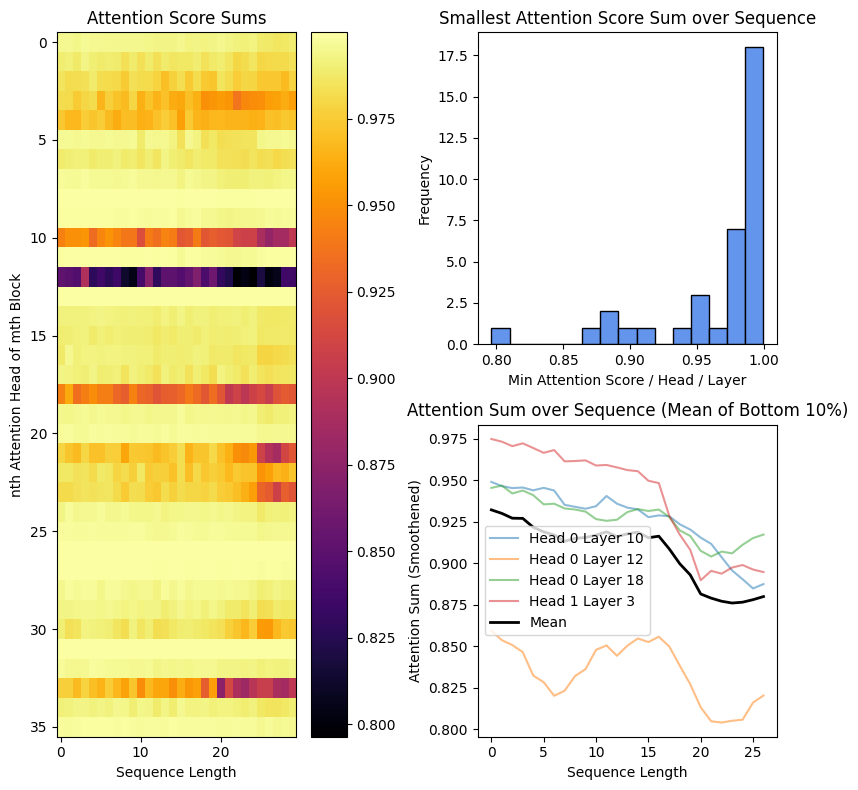

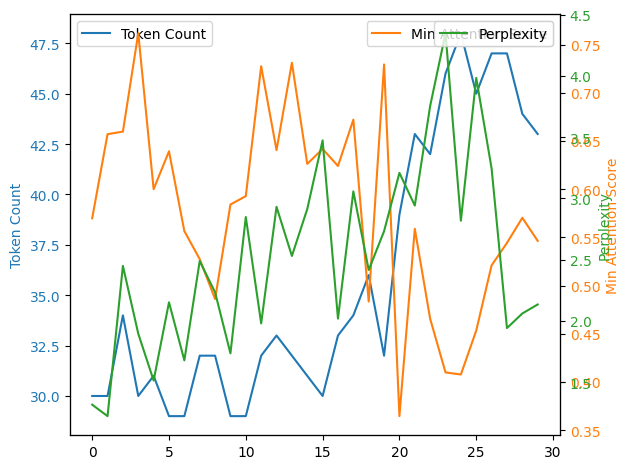

In [10]:
from collections import defaultdict
from tqdm import tqdm

perplexity_ab_prompts = [
		# Preschool
		"Once upon a time,",
		"Lily loved to play",
		"Jack and Jill went up the hill,",
		"Bob saw the playground",
		"A long long time ago,",
		# 1st grade
		"Sunny the bear",
		"Lucy found a magic",
		"Timmy's pet frog",
		"Emily's first day at",
		"In a land of",
		# Middle school
		"Lost in a virtual",
		"Ella's science experiment went",
		"Enchanted forest appeared overnight,",
		"Robots gaining human emotions",
		"Alien communication through coded",
		# PhD
		"Revolutionizing quantum computing:",
		"Unraveling the complexities of",
		"Ethics in AI: Unveiling",
		"Galactic anomalies challenge astrophysicists",
		"Synthesizing novel compounds for",
		# Academia-speak
		"Transdimensional hyperflux in the metaquantum entanglement matrix",
		"Hyperdimensional hypercognition catalyzes the entanglement of metasemiotic",
		"Epistemological deconstruction of hypercontextual postulates deconstructs",
		"Nonlocal retrocausal quantum hermeneutics deconstruct spacetime's metanarrative",
		"Metasemiotic metamorphosis transmutes logocentric paradigms into kaleidoscopic",
		# SHA256 hashes
		"e3b0c44298fc1c149afbf4c",
		"cf83e1357eefb8bdf1542850",
		"b2f5ff47436671b6e533d8d",
		"da39a3ee5e6b4b0d3255b",
		"77de68daecd823babbb58e",
]

ppl_data = defaultdict(list)

print(f"Generating {len(perplexity_ab_prompts)} samples...")

for prompt in tqdm(perplexity_ab_prompts):
	ppl_data['ppl'].append(compute_perplexity(prompt))
	ppl_data['completion'].append(generate(prompt=prompt))
	from model import softmax_sum
	S = torch.stack(softmax_sum)
	ppl_data['count'].append(S.shape[2])
	ppl_data['min'].append(S.min().item())
	S_mean = S.flatten(0,1).mean(-1)
	ppl_data['S'].append(S_mean)

S = torch.stack(ppl_data['S'], dim=1)
print('\n'.join([f'- {s[:100]}' for s in ppl_data['completion']]))
attnsum_all(S)

# Sample data for demonstration
timesteps = list(range(len(ppl_data['count'])))  # Assuming lists are of the same length
lists = [ppl_data['count'], ppl_data['min'], ppl_data['ppl']]
list_labels = ['Token Count', 'Min Attention Score', 'Perplexity']
list_colors = ['tab:blue', 'tab:orange', 'tab:green']

# Call the function to plot the data
plot_multi_scale_line_chart(timesteps, lists, list_labels, list_colors)